# Analyze single mutation data from the Cartesian ddG benchmark from Frenz et al.

## Import `Python` modules

In [1]:
import os
import sys
import subprocess
import pandas
import glob
import random
import re
import shutil
import Bio
from Bio.PDB import PDBList
import Bio.Alphabet
import math
import sklearn.metrics
import time
import numpy as np
import scipy.stats
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

import pyrosetta
pyrosetta.init('-cryst:crystal_refine -read_only_ATOM_entries -mute all')

# custom modules
sys.path.append('scripts/')
import design_utils
import scoring_utils

resultsdir = '/net/scratch/haddox/2021/cart_ddg_benchmark/results_240414/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Make a list of energy functions to test

In [2]:
e_function_dict = {
    'beta16' : {
        'weights_file' : 'beta_nov16_cart',
        'flags_file' : None,
        'extra_args' : ['-beta_nov16_cart']
    },
    'beta16_cart' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16',
        'extra_args' : []
    },
    'beta16_cart_plus_hpsc_lj_changes' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart_plus_lj_changes.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta16_plus_hpsc_lj_changes_flags',
        'extra_args' : []
    },
    
    # 'beta16_cart_plus_lj_changes' : {
    #     'weights_file' : \
    #         '/home/haddox/2019/optE_eval/data/beta_nov16_cart_plus_lj_changes.wts',
    #     'flags_file' :
    #         '/home/haddox/2019/optE_eval/data/flags_beta16',
    #     'extra_args' : []
    # },
    'beta16.nostab-refit' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16',
        'extra_args' : []
    },
    'beta16_plus_hpsc_lj_changes' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta16_plus_hpsc_lj_changes_flags',
        'extra_args' : []
    },
    
    'beta16.nostab-refit2' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16',
        'extra_args' : []
    },
    'beta16.nostab-refit_layer' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart_layer.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16',
        'extra_args' : []
    },
    'beta16.nostab-refit_dd2_elec_5h_res0.5' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16_dd2_elec_5h_res0.5',
        'extra_args' : []
    },
    'beta16.nostab-refit_dd2_elec_6a' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16_dd2_elec_6a',
        'extra_args' : []
    },
    'beta16.nostab-refit_dd_elec_5h_res0.5' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart_dd_elec.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16_dd_elec_5h_res0.5',
        'extra_args' : []
    },
    
    
    'HH_run19A_step266' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266',
        'extra_args' : []
    },
    'HH_run19A_step266_layer' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_layer.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5h_res0.5' : {
        'weights_file' : \
                '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd2_elec_5h.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5h_res0.5',
        'extra_args' : []
    },
    'HH_run19A_step266_dd2_elec_5e' : {
        'weights_file' : \
                '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266_dd2_elec_5e.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266_dd2_elec_5e',
        'extra_args' : []
    },
    
    
    'HH_run23A_step384' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23A_weights_384.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23A_flags_384',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_1a' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1a',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_1b' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1b',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_1c' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1c',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_1d' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1d',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_1e' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1e',
        'extra_args' : []
    },
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cfnp_5a3_14',
        'extra_args' : []
    },
    
}

## Read in the list of mutations included in the benchmark

Read in dataframe with ddG data for each mutation in the benchmark

In [3]:
# Dataframe 2
f = 'data/Data_Sheet_2_Prediction of Protein Mutational Free Energy_ Benchmark and Sampling Improvements Increase Classification Accuracy.CSV'
ddg2_df = pandas.read_csv(f)
print(f"Read in dataframe 2 with length of {len(ddg2_df)}")
pdb_codes_2 = list(set(ddg2_df['PDB ID']))
balanced_ids = set(ddg2_df['Protherm ID'].unique())
print(f"with {len(pdb_codes_2)} unique PDBs and {len(balanced_ids)} mut ids")

# Dataframe 3
f = 'data/Data_Sheet_3_Prediction of Protein Mutational Free Energy_ Benchmark and Sampling Improvements Increase Classification Accuracy.CSV'
ddg3_df = pandas.read_csv(f)
print(f"Read in a dataframe 3 with length of {len(ddg3_df)}")
pdb_codes_3 = list(set(ddg3_df['PDB ID']))
all_ids = set(ddg3_df['Protherm ID'].unique())
print(f"with {len(pdb_codes_3)} unique PDBs and {len(all_ids)} mut ids")
assert sum([balanced_id not in all_ids for balanced_id in balanced_ids]) == 0

# Concatenate dataframes
ddg_df = ddg3_df.copy()
pdb_codes = list(set(ddg_df['PDB ID']))

Read in dataframe 2 with length of 768
with 84 unique PDBs and 768 mut ids
Read in a dataframe 3 with length of 2971
with 119 unique PDBs and 2971 mut ids


In [4]:
pdb_codes_file = os.path.join(resultsdir, 'pdb_codes.txt')
with open(pdb_codes_file, 'w') as f:
    for pdb_code in pdb_codes:
        f.write(f'{pdb_code}\n')

## Download PDBs of wild-type proteins

Download crystal structures of proteins

In [5]:
import urllib.request

In [6]:
pdbl = PDBList()
pdb_dir = os.path.join(resultsdir, 'native_pdbs/')
if not os.path.isdir(pdb_dir):
    os.makedirs(pdb_dir)
    print('Made directory')
    raise ValueError()
    for pdb_code in pdb_codes:
        print(pdb_code)
        urllib.request.urlretrieve(
            f'http://files.rcsb.org/download/{pdb_code}.pdb',
            f'/net/scratch/haddox/2021/cart_ddg_benchmark/results_240414/native_pdbs/{pdb_code}.pdb'
        )
        #pdbl.retrieve_pdb_file(pdb_code, pdir=pdb_dir, file_format='pdb')

For each mutation in the dataset, make a PDB with just a single chain that has the mutated site

In [7]:
# Cycle through all native PDBs. For each, cycle through
# all chains, and save individual chains if the chain
# is in the mutation dataset.
output_dir = os.path.join(resultsdir, 'native_pdb_chains/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for pdb_code in pdb_codes:
    
    continue
    
    # if pdb_code != '1ONC':
    #     continue
    if pdb_code in [
        '1IR3', '1YCC', '2TS1', '2HPR', '1CLW', '1AM7', '1YEA', '1WQ5', '1RHG', '2CRK',
        '1ACB', '1PIN',
    ]:
        continue
    
    # Get data for native
    print('\n###')
    print(pdb_code)
    data = ddg_df[ddg_df['PDB ID'] == pdb_code]
    
    # Get a list of all chains in the mutation dataset
    target_chains = list(set(data['Chain']))
    print(target_chains)
    
    # Cycle through all chains and save PDBs of ones in the
    # dataset
    #native_pdb = os.path.join(pdb_dir, f'pdb{pdb_code.lower()}.ent')
    native_pdb = os.path.join(pdb_dir, f'{pdb_code}.pdb')
    if not os.path.isfile(native_pdb):
        continue
    pose = pyrosetta.pose_from_pdb(native_pdb)
    pose_chains = pose.split_by_chain()
    for pose_chain in pose_chains:
        if 'Z' in pose_chain.sequence():
            continue
        chain_name = pose_chain.pdb_info().chain(1)
        if chain_name in target_chains:
            output_file = os.path.join(
                output_dir,
                f'{pdb_code}_{chain_name}.pdb'
            )
            if not os.path.isfile(output_file):
                print(output_file)
                pose_chain.dump_pdb(output_file)
                print(chain_name, pose_chain.size(), pose_chain.sequence())

For each chain extracted above, relax the chain with 20 replicates

In [8]:
# Define input variables
relax_app_path = '/home/haddox/Rosetta/main/source/bin/relax.default.linuxgccrelease'
relax_space = 'cartesian' # 'dualspace' # 
relax_script = 'MonomerDesign2019'
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16_cart_plus_lj_changes',
    #'beta16',
    #'beta16.nostab-refit',
    #'beta16_plus_hpsc_lj_changes',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14'
]

# Relax each native PDB chain with each energy function
input_pdbs = glob.glob(os.path.join(
    resultsdir, 'native_pdb_chains/*.pdb'
))
replicates = [1] #, 2, 3, 4]
njobs = 0
for input_pdb in input_pdbs:
    for e_function in e_functions:
        
        continue
        
        weights_file = e_function_dict[e_function]['weights_file']
        flags_file = e_function_dict[e_function]['flags_file']
        extra_args = list(e_function_dict[e_function]['extra_args'])
        extra_args += [
            '-nstruct 5',
            '-relax:constrain_relax_to_start_coords',
            '-relax:ramp_constraints false',
            '-relax:coord_constrain_sidechains',
            #'-default_repeats 10',
            #'-relax:constrain_relax_to_start_coords',
            #'-set_weights coordinate_constraint 0.01',
        ]
        for replicate in replicates:
            output_dir = os.path.join(
                resultsdir,
                'relax_native_chain/',
                os.path.basename(input_pdb).replace('.pdb', ''),
                e_function,
                f'rep{replicate}/'
            )
            scores_file_prefix = os.path.join(output_dir, 'relax')
            if not os.path.isdir(output_dir):
                print(
                    os.path.basename(input_pdb).replace('.pdb', ''),
                    e_function,
                    replicate
                )
                os.makedirs(output_dir)
                design_utils.relax_design(
                    relax_app_path=relax_app_path,
                    input_pdbs=[input_pdb],
                    weights_file=weights_file,
                    results_dir=output_dir,
                    scores_file_prefix=scores_file_prefix,
                    relax_space=relax_space,
                    relax_script=relax_script,
                    extra_args=extra_args,
                    flags_file=flags_file,
                    submit_sbatch_job=True,
                    queue_type='cpu',
                    memory='2g',
                )
                njobs += 1
                if njobs > 300:
                    break

For each native, read in scores of replicate relaxes and choose the replicate with the best score for downstream analysis.

In [9]:
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16_cart_plus_lj_changes',
    #'beta16',
    #'beta16.nostab-refit',
    #'beta16_plus_hpsc_lj_changes',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
replicates = [1] # , 2, 3, 4]
best_input_pdbs_across_reps_dict = {}
for input_pdb in input_pdbs:
    input_pdb_code = os.path.basename(input_pdb).replace('.pdb', '')
    # if input_pdb_code != '1AMQ_A':
    #     continue
    best_input_pdbs_across_reps_dict[input_pdb_code] = {}
    for e_function in e_functions:
        best_score_across_reps = 1e6
        all_reps = 0
        for replicate in replicates:

            # Get score file for energy function
            score_file = os.path.join(
                resultsdir,
                'relax_native_chain',
                input_pdb_code,
                e_function,
                f'rep{replicate}',
                'relax.sc'
            )
            if not os.path.isfile(score_file):
                continue
            df = pandas.read_csv(score_file, sep='\s+', skiprows=1)
            all_reps += len(df)
            if len(df) < 4:
                raise ValueErorr(input_pdb)
                continue

            # Identify the PDB from the replicate relaxes that
            # scored the best
            if False:
                print(
                    e_function,
                    replicate,
                    len(df),
                    round(df['total_score'].min(), 2),
                    round(df['total_score'].max(), 2),
                    round(df['ref'].min(), 2),
                    round(df['ref'].max(), 2),
                )
            df.sort_values('total_score', ascending=True, inplace=True)
            best_score = df['total_score'].iloc[0]
            best_pdb = df['description'].iloc[0] + '.pdb'
            assert os.path.isfile(best_pdb), best_pdb

            # Update the best-scoring PDB if necessary
            if best_score < best_score_across_reps:
                best_score_across_reps = best_score
                best_pdb_across_reps = best_pdb

        # Record best-scoring PDB for energy function across replicates
        if True: # all_reps == 20:
            best_input_pdbs_across_reps_dict[input_pdb_code][e_function] = best_pdb_across_reps

## Use the `cartesian_ddg` application to predict the effect of each mutation

Make one input file per mutant, and then carry out the protocol for each mutant.

In [10]:
# Define the path to the ddG application and database
cartesian_ddg_path = '/home/haddox/Rosetta/main/source/bin/cartesian_ddg.default.linuxgccrelease'
databasepath = '/home/haddox/Rosetta/main/database/'

# Define inputs for ddG application
relax_space_name = 'cartesian' #'dualspace' #'torsion'
n_ddg_iterations = 5
dump_pdbs = False
bb_dof = 1
cwd = os.getcwd().replace('/mnt/', '/')
aas = Bio.Alphabet.IUPAC.IUPACProtein().letters

# Cycle over input PDBs and energy functions
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16_cart_plus_lj_changes',
    #'beta16',
    #'beta16.nostab-refit',
    #'beta16_plus_hpsc_lj_changes',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
nruns = 0
for input_pdb in input_pdbs:
    
    continue
    # if '1AMQ_A' not in input_pdb:
    #     continue
    
    input_pdb_code = os.path.basename(input_pdb).replace('.pdb', '')
    (pdb_id, chain_id) = input_pdb_code.split('_')
    original_input_pdb = os.path.join(
        resultsdir,
        'native_pdb_chains',
        f'{input_pdb_code}.pdb'
    )
    assert os.path.isfile(original_input_pdb)
    
    if pdb_id in ['1AYF', '1TPK', '1DIL']:
        continue
    
    if len(best_input_pdbs_across_reps_dict[input_pdb_code]) == 0:
        continue
    
    for e_function in e_functions:
    
        # Get files for energy funciton
        if e_function not in best_input_pdbs_across_reps_dict[input_pdb_code]:
            continue
        weights_file = e_function_dict[e_function]['weights_file']
        flags_file = e_function_dict[e_function]['flags_file']
        extra_args = list(e_function_dict[e_function]['extra_args'])
        input_pdb = best_input_pdbs_across_reps_dict[input_pdb_code][e_function]

        # Define the output directory
        output_dir = os.path.join(
            resultsdir,
            'cartesian_ddg',
            input_pdb_code,
            f'{e_function}/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
            
        # Make a dictionary that goes between PDB numbering and
        # sequential renumbering
        pose = pyrosetta.pose_from_pdb(original_input_pdb)
        renum_dict = {}
        for seq_n in range(1, pose.size()+1):
            pdb_n = pose.pdb_info().number(seq_n)
            renum_dict[str(pdb_n)] = seq_n
            
        # Get ddG entries for the indicated PDB and chain, and then
        # run the ddG computation on each one
        data = ddg_df[
            (ddg_df['PDB ID'] == pdb_id) &
            (ddg_df['Chain'] == chain_id)
        ]
        for (i, row) in data.iterrows():
            site = row['Residue Number']
            if site not in renum_dict:
                continue
            renum_site = renum_dict[site]
            wt_aa = row['Wild Type']
            mut_aa = row['Mutation']

            # Make an input file with information on a mutation,
            # using the PDB numbering for the site name for book-
            # keeping purposes, but using the sequentially renumbered
            # site in the file's contents
            mutant_name = f'{wt_aa}{site}{mut_aa}'
            mut_file = os.path.join(output_dir, f'{mutant_name}.txt')
            if not os.path.isfile(mut_file):
                with open(mut_file, 'w') as f:
                    f.write('total 1\n')
                    f.write('1\n')
                    f.write(f'{wt_aa} {renum_site} {mut_aa}\n')

            # Make the command-line argument
            scores_file_prefix = os.path.join(output_dir, mutant_name)
            cmd = ' '.join([
                cartesian_ddg_path,
                '-database {0}'.format(databasepath),
                '-s {0}'.format(os.path.join(cwd, input_pdb)),
                '-ddg:mut_file {0}'.format(os.path.join(cwd, mut_file)),
                '-ddg:iterations {0}'.format(n_ddg_iterations),
                '-ddg::cartesian',
                '-ddg::dump_pdbs {0}'.format(dump_pdbs),
                '-ddg:bbnbrs {0}'.format(bb_dof),
                '-ddg::legacy false',
                #'-fa_max_dis {0}'.format(fa_max_dis), # set to 9 A
                '-out:prefix {0}'.format(os.path.join(cwd, output_dir)),
                '-out:file:scorefile {0}.sc'.format(
                    os.path.join(cwd, scores_file_prefix)
                ),
                '-score:weights {0}'.format(weights_file),
                '-crystal_refine'
            ])

            # Add extra aguments if appropriate
            if extra_args:
                for arg in extra_args:
                    cmd += ' {0}'.format(arg)

            # If `flags_file` is provided, add it to the command
            if flags_file:
                cmd += ' @{0}'.format(flags_file)

            # Write an sbatch file to carry out the command
            sbatch_file_name = os.path.join(
                cwd,
                '{0}.sbatch'.format(scores_file_prefix)
            )
            if not os.path.isfile(sbatch_file_name):
                design_utils.WriteSbatchFile(
                    sbatch_file_name,
                    command=cmd,
                    queue_type='cpu',
                    memory='2g'
                )
                cmd = ['sbatch', sbatch_file_name]
                process = subprocess.Popen(
                    cmd, stdout=subprocess.PIPE,
                    cwd=output_dir
                )
                nruns += 1
                if nruns > 100:
                    raise ValueError(f'test {sbatch_file_name}')

Read in scores from `cartesian_ddg` protocol

In [11]:
ddg_scores_dict = {
    key : []
    for key in [
        'pdb', 'chain', 'e_function', 'mutation',
        'avg_wt', 'avg_mut', 'min_wt', 'min_mut',
    ]
}
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16_cart_plus_lj_changes',
    #'beta16',
    # 'beta16.nostab-refit',
    # 'beta16_plus_hpsc_lj_changes',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
for input_pdb in input_pdbs:
    input_pdb_code = os.path.basename(input_pdb).replace('.pdb', '')
    (pdb_id, chain_id) = input_pdb_code.split('_')
    for e_function in e_functions:
        output_dir = os.path.join(
            resultsdir,
            'cartesian_ddg',
            input_pdb_code,
            f'{e_function}/'
        )
        if not os.path.isdir(output_dir):
            continue
        ddg_fs = glob.glob(os.path.join(output_dir, '*.ddg'))
        if len(ddg_fs) == 0:
            print(f'Missing files for {input_pdb_code} {e_function} {output_dir}')
            continue
        for ddg_f in ddg_fs:

            # Read in scores across replicates
            wt_scores = []
            mut_scores = []
            with open(ddg_f) as f:
                lines = f.readlines()
            for line in lines:

                # Search for a WT score
                wt_pattern = r'WT_:\W+(?P<wt_score>-\d+.\d+)'
                match = re.search(wt_pattern, line)
                if match:
                    wt_scores.append(float(match.group('wt_score')))

                # Search for a mut score
                mut_pattern = r'MUT_\w+:\W+(?P<mut_score>-\d+.\d+)'
                match = re.search(mut_pattern, line)
                if match:
                    mut_scores.append(float(match.group('mut_score')))

            if len(mut_scores) == 0:
                continue
                    
            ddg_scores_dict['pdb'].append(pdb_id)
            ddg_scores_dict['chain'].append(chain_id)
            ddg_scores_dict['e_function'].append(e_function)
            ddg_scores_dict['mutation'].append(
                os.path.basename(ddg_f).replace('.ddg', '')
            )
            ddg_scores_dict['avg_wt'].append(np.mean(wt_scores))
            ddg_scores_dict['avg_mut'].append(np.mean(mut_scores))
            ddg_scores_dict['min_wt'].append(np.min(wt_scores))
            ddg_scores_dict['min_mut'].append(np.min(mut_scores))

ddg_scores_df = pandas.DataFrame(ddg_scores_dict)
ddg_scores_df['ddg'] = ddg_scores_df['avg_mut'] - ddg_scores_df['avg_wt']
print("Clipping ddg values")
ddg_scores_df['ddg'] = ddg_scores_df['ddg'].clip(upper=10)
ddg_scores_df = ddg_scores_df.pivot_table(
    index=['pdb', 'chain', 'mutation'], columns='e_function',
    values='ddg'
)
ddg_scores_df.reset_index(inplace=True)

# Merge computed ddGs with experimental data from above
data = ddg_df.copy()
data.rename(
    columns={
        'PDB ID' : 'pdb',
        'Protherm ID' : 'protherm_id',
        'Chain' : 'chain',
        'Residue Number' : 'site',
        'Wild Type' : 'wt_aa',
        'Mutation' : 'mut_aa',
        'SASA' : 'sasa',
        'Experimental DDG' : 'exp_ddg',
        'Classifiers' : 'classifiers',
    },
    inplace=True
)
data['mutation'] = data.apply(
    lambda row: '{0}{1}{2}'.format(row['wt_aa'], row['site'], row['mut_aa']),
    axis=1
)
ddg_scores_df = ddg_scores_df.merge(
    data, on=['pdb', 'chain', 'mutation']
)
print('len before dropping na', len(ddg_scores_df))

score_cols = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    'exp_ddg'
]
ddg_scores_df = ddg_scores_df.dropna(subset=score_cols)

print('len after dropping na', len(ddg_scores_df))

Clipping ddg values
len before dropping na 2764
len after dropping na 2763


In [12]:
ddg_scores_df[[
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    'exp_ddg'
]].isnull().any()

beta16_cart                         False
beta16_cart_plus_hpsc_lj_changes    False
exp_ddg                             False
dtype: bool

Write the scores to an output file

In [13]:
if False:
    ddg_scores_df.to_csv('results/final_scores_250417.csv')
    ddg_scores_df[
        ddg_scores_df['protherm_id'].isin(balanced_ids)
    ].to_csv('results/balanced_ids_final_scores_250417.csv')

Plot the correlation between measured and predicted ddGs

735
R = 0.548


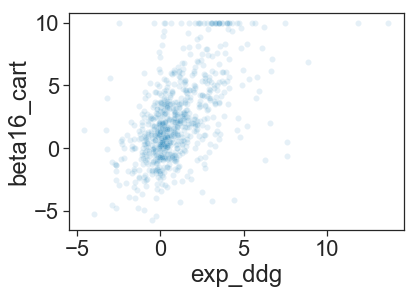

R = 0.547


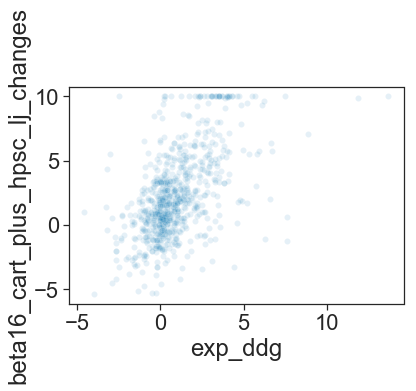

In [14]:
data = ddg_scores_df[
    ddg_scores_df['protherm_id'].isin(balanced_ids)
].copy()
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
print(len(data))
for e_function in e_functions:
    (r, p) = scipy.stats.pearsonr(data['exp_ddg'], data[e_function])
    print(f'R = {round(r, 3)}')
    sns.scatterplot(x='exp_ddg', y=e_function, data=data, alpha=0.1)
    plt.show()

* Pearson R is about the same both on full dataset and the balanced dataset from Frenz et al.
* Pearson R of 0.55 is a bit higher than the 0.49 reported in Frenz et al.
* median and average give similar results

To do:
* check Frenz paper and see which energy function and ref weights they used. ref2015?

Add columns indicating if mutations were correctly classified. Then test whether differences in classification accuracy are significantly different.

In [22]:
import numpy as np
from scipy.stats import chi2
from statsmodels.stats.contingency_tables import mcnemar

In [23]:
def classify_mut_effect(effect, cutoff=1):
    if effect < -cutoff:
        return 'stablizing'
    elif effect > cutoff:
        return 'destabilizing'
    else:
        return 'neutral'

# Get data for balanced ids
data = ddg_scores_df[
    ddg_scores_df['protherm_id'].isin(balanced_ids)
].copy()

# Classify mut effects
effect_cols = ['beta16_cart', 'beta16_cart_plus_hpsc_lj_changes', 'exp_ddg']
for col in effect_cols:
    data[f'{col}_class'] = data[col].apply(lambda x: classify_mut_effect(x))
for col in effect_cols:
    data[f'{col}_correct'] = data[f'{col}_class'] == data['exp_ddg_class']

data.head()

,pdb,chain,mutation,beta16_cart,beta16_cart_plus_hpsc_lj_changes,protherm_id,site,wt_aa,mut_aa,sasa,exp_ddg,classifiers,beta16_cart_class,beta16_cart_plus_hpsc_lj_changes_class,exp_ddg_class,beta16_cart_correct,beta16_cart_plus_hpsc_lj_changes_correct,exp_ddg_correct
0,1A2P,A,A32C,2.028,2.0978,59,32,A,C,0.792128,1.8381,'involves cysteine' 'surface',destabilizing,destabilizing,destabilizing,True,True,True
1,1A2P,A,A32D,0.177,0.1980,100,32,A,D,0.792128,0.4143,'hydrophobic to polar' 'hydrophobic to negativ...,neutral,neutral,neutral,True,True,True
2,1A2P,A,A32E,-0.640,-0.5930,223,32,A,E,0.792128,-0.1328,'small to large' 'hydrophobic to polar' 'hydro...,neutral,neutral,neutral,True,True,True
7,1A2P,A,A32K,-0.884,-0.8452,138,32,A,K,0.792128,0.1020,'small to large' 'hydrophobic to polar' 'hydro...,neutral,neutral,neutral,True,True,True
11,1A2P,A,A32P,10.000,10.0000,77,32,A,P,0.792128,4.1259,'involves proline' 'surface',destabilizing,destabilizing,destabilizing,True,True,True


In [29]:
# Create contingency table
# Count cases where:
both_correct = np.sum(data['beta16_cart_correct'] & data['beta16_cart_plus_hpsc_lj_changes_correct'])
beta_nov16_only = np.sum(data['beta16_cart_correct'] & ~data['beta16_cart_plus_hpsc_lj_changes_correct'])
beta_jan25_only = np.sum(~data['beta16_cart_correct'] & data['beta16_cart_plus_hpsc_lj_changes_correct'])
both_wrong = np.sum(~data['beta16_cart_correct'] & ~data['beta16_cart_plus_hpsc_lj_changes_correct'])

# McNemar's test focuses on discordant pairs
contingency_table = np.array([[both_correct, beta_nov16_only],
                             [beta_jan25_only, both_wrong]])

# Perform McNemar's test
result = mcnemar(contingency_table, exact=False, correction=True)
print(f"McNemar's test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

McNemar's test statistic: 0.0784313725490196
p-value: 0.779434528427275


In [27]:
contingency_table

array([[379,  27],
       [ 24, 305]])

In [2]:
(379 + 24) / 735

0.5482993197278911

Classify mutations as stabilizing (>1), destabilizing (<-1), neutral (+/- 1; or 2)

In [19]:
cutoff = 1
class_dict = {
    key : []
    for key in [
        'e_function',
        'true_stab', 'false_stab_neu', 'false_stab_de',
        'true_neu', 'false_neu_stab', 'false_neu_de',
        'true_de', 'false_de_neu', 'false_de_stab'
    ]
}
data = ddg_scores_df[
    ddg_scores_df['protherm_id'].isin(balanced_ids)
].copy()
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]
for e_function in e_functions:

    # Record data
    class_dict['e_function'].append(e_function)

    class_dict['true_stab'].append(sum(
        (data['exp_ddg'] < -cutoff) & (data[e_function] < -cutoff)
    ))
    class_dict['false_stab_neu'].append(sum(
        (data['exp_ddg'].between(-cutoff, cutoff)) & (data[e_function] < -cutoff)
    ))
    class_dict['false_stab_de'].append(sum(
        (data['exp_ddg'] > cutoff) & (data[e_function] < -cutoff)
    ))

    class_dict['true_neu'].append(sum(
        (data['exp_ddg'].between(-cutoff, cutoff)) & (data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_stab'].append(sum(
        (data['exp_ddg'] < -cutoff) & (data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_de'].append(sum(
        (data['exp_ddg'] > cutoff) & (data[e_function].between(-cutoff, cutoff))
    ))
    
    class_dict['true_de'].append(sum(
        (data['exp_ddg'] > cutoff) & (data[e_function] > cutoff)
    ))
    class_dict['false_de_neu'].append(sum(
        (data['exp_ddg'].between(-cutoff, cutoff)) & (data[e_function] > cutoff)
    ))
    class_dict['false_de_stab'].append(sum(
        (data['exp_ddg'] < -cutoff) & (data[e_function] > cutoff)
    ))

class_df = pandas.DataFrame(class_dict)
class_df = class_df.set_index('e_function').T # / len(all_data)
class_df

e_function,beta16_cart,beta16_cart_plus_hpsc_lj_changes
true_stab,27,28
false_stab_neu,53,61
false_stab_de,12,15
true_neu,140,137
false_neu_stab,22,21
false_neu_de,32,30
true_de,239,238
false_de_neu,195,190
false_de_stab,15,15


Compute the fraction of mutations that were correctly classified

In [20]:
data = class_df.copy()
data.loc['total_n_muts'] = data.sum(numeric_only=True)
data = data.T
data['n_correct'] = data['true_stab'] + data['true_neu'] + data['true_de']
data['n_incorrect'] = data['total_n_muts'] - data['n_correct']
data['frac_correct'] = data['n_correct'] / data['total_n_muts']
data.T

e_function,beta16_cart,beta16_cart_plus_hpsc_lj_changes
true_stab,27.000000,28.000000
false_stab_neu,53.000000,61.000000
false_stab_de,12.000000,15.000000
true_neu,140.000000,137.000000
false_neu_stab,22.000000,21.000000
false_neu_de,32.000000,30.000000
true_de,239.000000,238.000000
false_de_neu,195.000000,190.000000
false_de_stab,15.000000,15.000000
total_n_muts,735.000000,735.000000


In [21]:
from scipy.stats import chi2_contingency

In [22]:
# Create a contingency table (example data)
# Rows represent one categorical variable, columns represent another
contingency_table = np.array([
    [406, 403],  # First row
    [329, 332]    # Second row
])

# Run the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpret the result
alpha = 0.05
print("\nSignificance test:")
if p <= alpha:
    print(f"p-value {p:.6f} is less than alpha {alpha}, so we reject the null hypothesis.")
    print("There is a significant association between the variables.")
else:
    print(f"p-value {p:.6f} is greater than alpha {alpha}, so we fail to reject the null hypothesis.")
    print("There is no significant association between the variables.")

Chi-square statistic: 0.010995812988897595
P-value: 0.9164861675866135
Degrees of freedom: 1
Expected frequencies:
[[404.5 404.5]
 [330.5 330.5]]

Significance test:
p-value 0.916486 is greater than alpha 0.05, so we fail to reject the null hypothesis.
There is no significant association between the variables.


In [28]:
# Create a contingency table (example data)
# Rows represent one categorical variable, columns represent another
contingency_table = np.array([
    [1483, 1501],  # First row
    [932, 914]    # Second row
])

# Run the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpret the result
alpha = 0.05
print("\nSignificance test:")
if p <= alpha:
    print(f"p-value {p:.6f} is less than alpha {alpha}, so we reject the null hypothesis.")
    print("There is a significant association between the variables.")
else:
    print(f"p-value {p:.6f} is greater than alpha {alpha}, so we fail to reject the null hypothesis.")
    print("There is no significant association between the variables.")

Chi-square statistic: 0.2534045788444837
P-value: 0.6146879457873328
Degrees of freedom: 1
Expected frequencies:
[[1492. 1492.]
 [ 923.  923.]]

Significance test:
p-value 0.614688 is greater than alpha 0.05, so we fail to reject the null hypothesis.
There is no significant association between the variables.


OLD RESULTS

In [50]:
cutoff = 1
class_dict = {
    key : []
    for key in [
        'e_function',
        'true_stab', 'false_stab_neu', 'false_stab_de',
        'true_neu', 'false_neu_stab', 'false_neu_de',
        'true_de', 'false_de_neu', 'false_de_stab'
    ]
}
data = ddg_scores_df[
    ddg_scores_df['protherm_id'].isin(balanced_ids)
].copy()
e_functions = [
    'beta16.nostab-refit',
    'beta16_plus_hpsc_lj_changes'
]
for e_function in e_functions:

    # Record data
    class_dict['e_function'].append(e_function)

    class_dict['true_stab'].append(sum(
        (data['exp_ddg'] < -cutoff) & (data[e_function] < -cutoff)
    ))
    class_dict['false_stab_neu'].append(sum(
        (data['exp_ddg'].between(-cutoff, cutoff)) & (data[e_function] < -cutoff)
    ))
    class_dict['false_stab_de'].append(sum(
        (data['exp_ddg'] > cutoff) & (data[e_function] < -cutoff)
    ))

    class_dict['true_neu'].append(sum(
        (data['exp_ddg'].between(-cutoff, cutoff)) & (data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_stab'].append(sum(
        (data['exp_ddg'] < -cutoff) & (data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_de'].append(sum(
        (data['exp_ddg'] > cutoff) & (data[e_function].between(-cutoff, cutoff))
    ))
    
    class_dict['true_de'].append(sum(
        (data['exp_ddg'] > cutoff) & (data[e_function] > cutoff)
    ))
    class_dict['false_de_neu'].append(sum(
        (data['exp_ddg'].between(-cutoff, cutoff)) & (data[e_function] > cutoff)
    ))
    class_dict['false_de_stab'].append(sum(
        (data['exp_ddg'] < -cutoff) & (data[e_function] > cutoff)
    ))

class_df = pandas.DataFrame(class_dict)
class_df = class_df.set_index('e_function').T # / len(all_data)
class_df

e_function,beta16.nostab-refit,beta16_plus_hpsc_lj_changes
true_stab,26,26
false_stab_neu,56,58
false_stab_de,13,14
true_neu,139,137
false_neu_stab,23,22
false_neu_de,32,32
true_de,239,238
false_de_neu,193,193
false_de_stab,15,16


## Identify which sites in the benchmark are making H-bonds

Find H-bonds in the original crystal structures

In [10]:
pdb_dir = os.path.join(resultsdir, 'native_pdb_chains/')
output_file = os.path.join(pdb_dir, 'hbonds.csv')
cmd = ' '.join([
    'python',
    'scripts/analyze_hbnets/compute_hbond_energies.py',
    f'--pdb_dir {pdb_dir}',
    f'--output_file {output_file}',
    '--only_return_buried_hbonds False'
])
sbatch_file_name = output_file.replace('.csv', '.sbatch')
if not os.path.isfile(sbatch_file_name):
    design_utils.WriteSbatchFile(
        sbatch_file_name,
        command=cmd,
        queue_type='short',
        memory='2g',
    )
    ! sbatch {sbatch_file_name}

... and find electrostatic interactions within a given distance cutoff

In [11]:
pdb_dir = os.path.join(resultsdir, 'native_pdb_chains/')
output_file = os.path.join(pdb_dir, 'elec_int.csv')
cmd = ' '.join([
    'python',
    'scripts/find_charge_charge_interactions.py',
    f'--pdb_dir {pdb_dir}',
    f'--output_file {output_file}'
])
sbatch_file_name = output_file.replace('.csv', '.sbatch')
if not os.path.isfile(sbatch_file_name):
    design_utils.WriteSbatchFile(
        sbatch_file_name,
        command=cmd,
        queue_type='short',
        memory='2g',
    )
    ! sbatch {sbatch_file_name}

Also find H-bonds in best-scoring relaxed structures

In [12]:
# Make a new directory with best-scoring relaxed PDBs
e_function = 'beta16'
output_dir = os.path.join(resultsdir, 'best_scoring_pdbs', e_function)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for pdb_code in best_input_pdbs_across_reps_dict:
    input_pdb = best_input_pdbs_across_reps_dict[pdb_code][e_function]
    new_pdb = os.path.join(output_dir, os.path.basename(input_pdb))
    if not os.path.isfile(new_pdb):
        shutil.copy(input_pdb, new_pdb)

# Find H-bonds
output_file = os.path.join(output_dir, 'hbonds.csv')
cmd = ' '.join([
    'python',
    'scripts/analyze_hbnets/compute_hbond_energies.py',
    f'--pdb_dir {output_dir}',
    f'--output_file {output_file}',
    '--only_return_buried_hbonds False'
])
sbatch_file_name = output_file.replace('.csv', '.sbatch')
if not os.path.isfile(sbatch_file_name):
    design_utils.WriteSbatchFile(
        sbatch_file_name,
        command=cmd,
        queue_type='short',
        memory='2g',
    )
    ! sbatch {sbatch_file_name}

... and find electrostatic interactions within a given distance cutoff

In [13]:
e_function = 'beta16'
output_dir = os.path.join(resultsdir, 'best_scoring_pdbs', e_function)
output_file = os.path.join(output_dir, 'elec_int.csv')
cmd = ' '.join([
    'python',
    'scripts/find_charge_charge_interactions.py',
    f'--pdb_dir {output_dir}',
    f'--output_file {output_file}'
])
sbatch_file_name = output_file.replace('.csv', '.sbatch')
if not os.path.isfile(sbatch_file_name):
    print(sbatch_file_name)
    design_utils.WriteSbatchFile(
        sbatch_file_name,
        command=cmd,
        queue_type='short',
        memory='2g',
    )
    ! sbatch {sbatch_file_name}

Read in data and use it to annotate which sites in the ddG benchmark are making H-bonds

In [14]:
def count_hbonds(pdb, chain, site):
    site = int(site)
    return len(hb_df[
        ((hb_df['acc_pdb_res_n'] == site) | (hb_df['don_pdb_res_n'] == site)) &
        (hb_df['chain'] == chain) &
        (hb_df['pdb'] == pdb)
    ])

def count_charged_scsc_hbonds(pdb, chain, site):
    charged_aas = ['ASP', 'GLU', 'ARG', 'LYS', 'HIS']
    site = int(site)
    return len(hb_df[
        ((hb_df['acc_pdb_res_n'] == site) | (hb_df['don_pdb_res_n'] == site)) &
        (hb_df['acc_res_name'].isin(charged_aas)) &
        (hb_df['don_res_name'].isin(charged_aas)) &
        (~hb_df['acc_atom_is_bb']) &
        (~hb_df['don_atom_is_bb']) &
        (hb_df['chain'] == chain) &
        (hb_df['pdb'] == pdb)
    ])
    
# Read in H-bond data for crystal structures
f = os.path.join(resultsdir, 'native_pdb_chains/hbonds.csv')
hb_df = pandas.read_csv(f)
del hb_df['Unnamed: 0']
hb_df['pdb'] = hb_df['pdb_basename'].apply(
    lambda x: x.replace('.pdb', '').split('_')[0]
)
hb_df['chain'] = hb_df['pdb_basename'].apply(
    lambda x: x.replace('.pdb', '').split('_')[1]
)
ddg_scores_df['n_hbonds'] = ddg_scores_df.apply(
    lambda row: count_hbonds(row['pdb'], row['chain'], row['site']),
    axis=1
)
ddg_scores_df['n_charged_scsc_hbonds'] = ddg_scores_df.apply(
    lambda row: count_charged_scsc_hbonds(row['pdb'], row['chain'], row['site']),
    axis=1
)

# Do the same thing for relaxed structures
f = os.path.join(resultsdir, 'best_scoring_pdbs/beta16/hbonds.csv')
hb_df = pandas.read_csv(f)
del hb_df['Unnamed: 0']
hb_df['pdb'] = hb_df['pdb_basename'].apply(
    lambda x: x.replace('.pdb', '').split('_')[0]
)
hb_df['chain'] = hb_df['pdb_basename'].apply(
    lambda x: x.replace('.pdb', '').split('_')[1]
)
ddg_scores_df['n_hbonds_relaxed'] = ddg_scores_df.apply(
    lambda row: count_hbonds(row['pdb'], row['chain'], row['site']),
    axis=1
)
ddg_scores_df['n_charged_scsc_hbonds_relaxed'] = ddg_scores_df.apply(
    lambda row: count_charged_scsc_hbonds(row['pdb'], row['chain'], row['site']),
    axis=1
)

In [15]:
# ... and electrostatic interactions
# f = os.path.join(resultsdir, 'native_pdb_chains/hbonds.csv')
# hb_df = pandas.read_csv(f)
# del hb_df['Unnamed: 0']
# hb_df['pdb'] = hb_df['pdb_basename'].apply(
#     lambda x: x.replace('.pdb', '').split('_')[0]
# )
# hb_df['chain'] = hb_df['pdb_basename'].apply(
#     lambda x: x.replace('.pdb', '').split('_')[1]
# )
# ddg_scores_df['n_hbonds'] = ddg_scores_df.apply(
#     lambda row: count_hbonds(row['pdb'], row['chain'], row['site']),
#     axis=1
# )

In [16]:
data = ddg_scores_df[
    (ddg_scores_df['pdb'] == '1A2P') &
    (ddg_scores_df['wt_aa'] == 'R')
].copy()
data['n_hbonds'] = data.apply(
    lambda row: count_hbonds(row['pdb'], row['chain'], int(row['site'])),
    axis=1
)
data.head()

,pdb,chain,mutation,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg,beta16_ddg,Protherm ID,site,wt_aa,mut_aa,sasa,exp_ddg,classifiers,n_hbonds,n_charged_scsc_hbonds,n_hbonds_relaxed,n_charged_scsc_hbonds_relaxed
111,1A2P,A,R110A,6.763,8.9410,94,110,R,A,0.520881,-0.07,'large to small' 'polar to hydrophobic' 'posit...,5,3,5,4
112,1A2P,A,R59A,1.208,2.0622,119,59,R,A,1.110547,-0.64,'large to small' 'polar to hydrophobic' 'posit...,2,0,2,2
113,1A2P,A,R69K,7.835,7.5876,164,69,R,K,0.281386,3.13,'charge to charge' 'buried',3,2,3,2
114,1A2P,A,R69M,6.524,5.0200,182,69,R,M,0.281386,2.12,'polar to hydrophobic' 'positive to hydrophobi...,3,2,3,2
115,1A2P,A,R69S,7.626,6.3050,114,69,R,S,0.281386,2.72,'large to small' 'positive to non-charged pola...,3,2,3,2


Analyze data for specific sites

2958 157


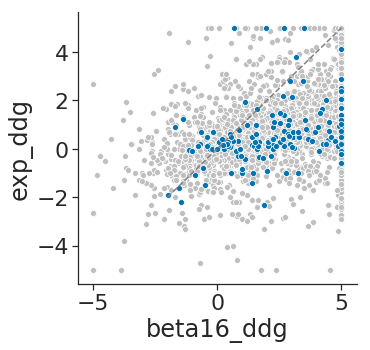

In [17]:
sasa_cutoff = 0.5
all_data = ddg_scores_df[
    #(ddg_scores_df['sasa'] > 0.2) &
    (ddg_scores_df['n_hbonds'] >= 0)
].copy()
data = ddg_scores_df[
    (ddg_scores_df['sasa'] > sasa_cutoff) &
    (ddg_scores_df['n_hbonds'] > 0)
].copy()
print(len(all_data), len(data))

clip = 5
for metric in ['beta16_ddg', 'exp_ddg']:
    data[metric] = data[metric].clip(upper=clip, lower=-clip)
    all_data[metric] = all_data[metric].clip(upper=clip, lower=-clip)
plt.figure(figsize=[5,5])
plt.plot([-2,5], [-2,5], ls='--', c='0.5')
sns.scatterplot(x='beta16_ddg', y='exp_ddg', data=all_data, color='0.75')
sns.scatterplot(x='beta16_ddg', y='exp_ddg', data=data)
sns.despine()
plt.show()

1.2264333333333326


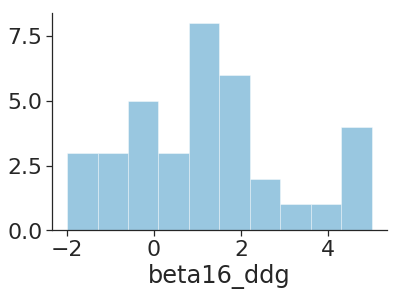

In [18]:
data_i = data[data['exp_ddg'] <= 0]
print(data_i['beta16_ddg'].mean())
sns.distplot(data_i['beta16_ddg'], kde=False, bins=10)
sns.despine()
plt.show()

In [19]:
data[
    (data['exp_ddg'] < 0) &
    (data['beta16_ddg'] > 2)
]

,pdb,chain,mutation,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg,beta16_ddg,Protherm ID,site,wt_aa,mut_aa,sasa,exp_ddg,classifiers,n_hbonds,n_charged_scsc_hbonds,n_hbonds_relaxed,n_charged_scsc_hbonds_relaxed
111,1A2P,A,R110A,6.7630,5.0000,94,110,R,A,0.520881,-0.07,'large to small' 'polar to hydrophobic' 'posit...,5,3,5,4
249,1BOY,A,R200W,NaN,5.0000,252,200,R,W,0.569469,-0.60,'polar to hydrophobic' 'positive to hydrophobi...,1,0,2,0
261,1BPI,A,D3A,1.5872,5.0000,296,3,D,A,0.774806,-0.20,'polar to hydrophobic' 'negative to hydrophobi...,1,0,2,2
1337,1POH,A,K49G,4.5790,2.7740,1265,49,K,G,0.628835,-1.00,'large to small' 'polar to hydrophobic' 'posit...,1,0,1,0
1406,1RGG,A,Q38A,2.1482,3.2660,1326,38,Q,A,0.678942,-1.00,'large to small' 'polar to hydrophobic' 'non-c...,1,0,2,0
1408,1RGG,A,R40E,-2.1688,2.1764,1322,40,R,E,1.177442,-0.30,'positive to negative' 'surface',1,0,2,0
1836,1STN,A,K48A,4.4160,4.0826,1680,48,K,A,1.239155,-0.10,'large to small' 'polar to hydrophobic' 'posit...,1,0,1,0
1839,1STN,A,K48G,6.3720,5.0000,1730,48,K,G,1.239155,-0.20,'large to small' 'polar to hydrophobic' 'posit...,1,0,1,0


Read in data from different datasets and merge with dataset from above

In [20]:
datasets_dict = {
    'miniprotein_dms' : '/net/scratch/haddox/2021/cart_ddg_benchmark/results/rocklin_dms/ddg_scores.csv',
    'protein_gb1' : '/home/haddox/2021/protein_gb1_analysis/results/ddg_scores.csv',
}
dfs = [ddg_scores_df]
ddg_scores_df['dataset'] = 'ddg_benchmark'
for (name, f) in datasets_dict.items():
    df = pandas.read_csv(f)
    if 'exp_ddg' not in df.columns.values:
        df['exp_ddg'] = df['ddg']
    df['dataset'] = name
    dfs.append(df)
scores_df = pandas.concat(dfs, sort=False)
print(len(scores_df))

13253


Define alternative sets of reference weights

In [21]:
# For each set of new ref wts, make a dictionary that gives
# the paths to old and new ref wts
new_ref_wts = {
    'beta16_stab_ddg' : (
        'beta16_ddg',
        '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts',
        '/home/haddox/2019/optE_eval/data/beta_nov16.wts'
    ),
    'beta16_layer_ddg' : (
        'beta16_ddg',
        '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts',
        '/home/haddox/2019/optE_eval/results/beta_nov16/layer_nostab_0/opt_1/seqrecov_result'
    ),
    'beta16_uniform_ddg' : (
        'beta16_ddg',
        '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts',
        '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart_uniform_ref.wts',
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg' : (
        'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg',
        '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169_layer.wts',
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_uniform_ddg' : (
        'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg',
        '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '/home/haddox/2019/optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169_uniform_ref.wts',
    ),
}

Plot a given set of reference weights

beta16_layer_ddg


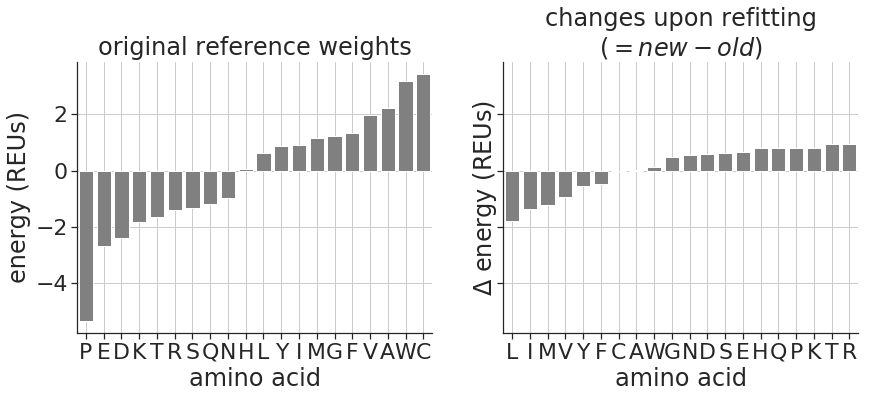

In [22]:
ref_wts_tag = 'beta16_layer_ddg'
print(ref_wts_tag)
(new_tag, std_file, new_file) = new_ref_wts[ref_wts_tag]

ref_wts_dict = {
    key : []
    for key in ['aa', 'type', 'wt']
}
aas = Bio.Alphabet.IUPAC.IUPACProtein().letters
for (wt_type, file) in [('std', std_file), ('new', new_file)]:
    with open(file) as f:
        lines = f.readlines()
    for line in lines:
        if 'METHOD_WEIGHTS' in line:
            ref_wts = line.strip().split()[2:]
    for (aa, ref_wt) in zip(aas, ref_wts):
        ref_wts_dict['aa'].append(aa)
        ref_wts_dict['type'].append(wt_type)
        ref_wts_dict['wt'].append(float(ref_wt))
        
ref_wts_df = pandas.DataFrame(ref_wts_dict)
ref_wts_df = ref_wts_df.pivot(index='aa', columns='type', values='wt')
ref_wts_df.reset_index(inplace=True)
ref_wts_df['diff'] = ref_wts_df['new'] - ref_wts_df['std']

# Plot data
(fig, axs) = plt.subplots(ncols=2, sharey=True, figsize=[14,5])

ref_wts_df.sort_values('std', inplace=True)
sns.barplot(x='aa', y='std', data=ref_wts_df, color='0.5', ax=axs[0])
axs[0].set(
    xlabel='amino acid', ylabel='energy (REUs)',
    title='original reference weights'
)
axs[0].grid()

ref_wts_df.sort_values('diff', inplace=True)
sns.barplot(x='aa', y='diff', data=ref_wts_df, ax=axs[1], color='0.5')
axs[1].set(
    xlabel='amino acid', ylabel='$\Delta$ energy (REUs)',
    title='changes upon refitting\n($=new - old$)'
)
axs[1].grid()
sns.despine()
plt.show()

Add columns that recompute existing scores with new reference weights

In [23]:
def adjust_ddg_from_delta_ref(ref_wts_df, wt_aa, mut_aa, old_ddg):
    wt_old = float(ref_wts_df.loc[wt_aa]['old'])
    wt_new = float(ref_wts_df.loc[wt_aa]['new'])
    mut_old = float(ref_wts_df.loc[mut_aa]['old'])
    mut_new = float(ref_wts_df.loc[mut_aa]['new'])
    wt_delta = wt_new - wt_old
    mut_delta = mut_new - mut_old
    delta_effect = mut_delta - wt_delta
    return old_ddg + delta_effect

for new_ddg_col in new_ref_wts:
    (old_ddg_col, old_file, new_file) = new_ref_wts[new_ddg_col]

    # Make a dataframe with old and new reference weights
    ref_wts_dict = {
        key : []
        for key in ['aa', 'type', 'wt']
    }
    aas = Bio.Alphabet.IUPAC.IUPACProtein().letters
    for (wt_type, file) in [('old', old_file), ('new', new_file)]:
        with open(file) as f:
            lines = f.readlines()
        for line in lines:
            if 'METHOD_WEIGHTS' in line:
                ref_wts = line.strip().split()[2:]
        for (aa, ref_wt) in zip(aas, ref_wts):
            ref_wts_dict['aa'].append(aa)
            ref_wts_dict['type'].append(wt_type)
            ref_wts_dict['wt'].append(float(ref_wt))

    ref_wts_df = pandas.DataFrame(ref_wts_dict)
    ref_wts_df = ref_wts_df.pivot_table(
        index='aa', columns='type', values='wt'
    )

    # Correct mutation effects
    wt_aa = 'R'
    mut_aa = 'V'
    old_ddg = 0
    print(old_ddg_col, new_ddg_col, adjust_ddg_from_delta_ref(ref_wts_df, wt_aa, mut_aa, old_ddg))
    scores_df[new_ddg_col] = scores_df.apply(
        lambda row: adjust_ddg_from_delta_ref(
            ref_wts_df,
            row['wt_aa'],
            row['mut_aa'],
            row[old_ddg_col]
        ),
        axis=1
    )

beta16_ddg beta16_stab_ddg -0.1701600000000001
beta16_ddg beta16_layer_ddg -1.88641
beta16_ddg beta16_uniform_ddg -3.39316
HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg -2.0274099999999997
HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_uniform_ddg -3.9642


Clip ddg values

In [24]:
ddg_cols = [
    col for col in scores_df.columns.values
    if '_ddg' in col
]
for ddg_col in ddg_cols:
    if ddg_col in ['ddg', 'exp_ddg']:
        continue
    scores_df[ddg_col] = scores_df[ddg_col].clip(lower=-2, upper=10)

In [25]:
scores_df[
    (scores_df['wt_aa'] == 'R') &
    (scores_df['mut_aa'] == 'V')
][[
    'mutation', 'beta16_ddg', 'beta16_layer_ddg',
    'beta16_stab_ddg', 'beta16_uniform_ddg',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_uniform_ddg',
]].head()

,mutation,beta16_ddg,beta16_layer_ddg,beta16_stab_ddg,beta16_uniform_ddg,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_uniform_ddg
806,R55V,0.9214,-0.96501,0.75124,-2.00000,0.4570,-2.0000
978,R96V,3.7024,1.81599,3.53224,0.30924,3.0024,-0.9618
474,R26V,1.8604,-0.02601,1.69024,-1.53276,NaN,NaN
491,R43V,-0.2200,-2.00000,-0.39016,-2.00000,NaN,NaN
2652,R13V,1.8614,-0.02501,1.69124,-1.53176,NaN,NaN


Analyze parts of the data

In [26]:
polar_aas = list('DEHKNQRST')
charged_aas = list('DEKR')
hydrophobic_aas = list('AFILMVWY')

EHEE_rd1_0882
[19, 22, 26]
289 681
beta16_ddg


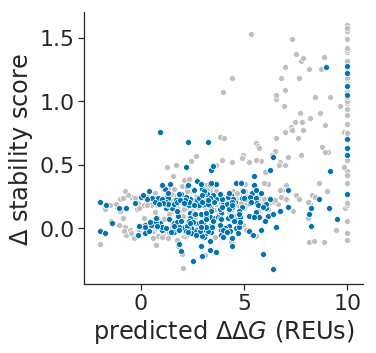

In [42]:
dataset = 'miniprotein_dms'
pdb = 'EHEE_rd1_0882' # 'HHH_rd1_0142' # 'EEHEE_rd3_0037' # 'EEHEE_rd3_0037' # 'HEEH_rd3_0872' # 'EHEE_rd1_0882' # 
sites = [
    19, 22, 26
    #22
    #23, 27, 42
    #35
]
print(pdb)
print(sites)
all_data = scores_df[
    #(scores_df['wt_aa'].isin(polar_aas)) &
    (scores_df['pdb'] == pdb) &
    #(scores_df['n_hbonds'] > 0) &
    (scores_df['dataset'] == dataset)
].copy()
data = scores_df[
    #(scores_df['wt_aa'].isin(polar_aas)) &
    #(scores_df['site'].isin(sites)) &
    (scores_df['n_hbonds'] > 0) &
    (scores_df['pdb'] == pdb) &
    (scores_df['dataset'] == dataset)
].copy()
print(len(data), len(all_data))

clip = 10
ddg_metric = 'beta16_ddg' # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg' # 'beta16_uniform_ddg' # ,'beta16_layer_ddg'
print(ddg_metric)
for metric in [ddg_metric, 'exp_ddg']:
    data[metric] = data[metric].clip(upper=clip, lower=-clip)
    all_data[metric] = all_data[metric].clip(upper=clip, lower=-clip)
plt.figure(figsize=[5,5])
#plt.plot([-2,5], [-2,5], ls='--', c='0.5')
if False:
    plt.hist2d(x=all_data[ddg_metric], y=all_data['exp_ddg'], bins=20)
else:    
    sns.scatterplot(x=ddg_metric, y='exp_ddg', data=all_data, color='0.75')
    sns.scatterplot(x=ddg_metric, y='exp_ddg', data=data)

plt.xlabel('predicted $\Delta \Delta G$ (REUs)')
plt.ylabel('$\Delta$ stability score')
sns.despine()
plt.show()

In [38]:
data[
    (data['exp_ddg'] < 0.1) &
    (data['beta16_ddg'] > 7)
].head(n=10)

,pdb,chain,mutation,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg,beta16_ddg,Protherm ID,site,wt_aa,mut_aa,sasa,...,beta16.nostab-refit_ddg,beta16.nostab-refit_layer_ddg,n_scsc_hbonds_relaxed,n_elec_int,n_elec_int_relaxed,beta16_stab_ddg,beta16_layer_ddg,beta16_uniform_ddg,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_uniform_ddg
7295,HHH_rd1_0142,NaN,E19P,NaN,8.0460,NaN,19,E,P,NaN,...,NaN,NaN,NaN,NaN,NaN,10.000000,8.199320,10.000000,NaN,NaN
7305,HHH_rd1_0142,NaN,E20G,NaN,8.1570,NaN,20,E,G,NaN,...,NaN,NaN,NaN,NaN,NaN,7.807400,7.987130,4.235630,NaN,NaN
7404,HHH_rd1_0142,NaN,E4A,NaN,7.4510,NaN,4,E,A,NaN,...,NaN,NaN,NaN,NaN,NaN,7.128570,6.797070,2.554370,NaN,NaN
7406,HHH_rd1_0142,NaN,E4F,NaN,7.6300,NaN,4,E,F,NaN,...,NaN,NaN,NaN,NaN,NaN,7.404620,6.492250,3.629620,NaN,NaN
7407,HHH_rd1_0142,NaN,E4G,NaN,8.3316,NaN,4,E,G,NaN,...,NaN,NaN,NaN,NaN,NaN,7.982000,8.161730,4.410230,NaN,NaN
7412,HHH_rd1_0142,NaN,E4M,NaN,8.3610,NaN,4,E,M,NaN,...,NaN,NaN,NaN,NaN,NaN,7.861250,6.487543,4.517290,NaN,NaN
7413,HHH_rd1_0142,NaN,E4N,NaN,7.1360,NaN,4,E,N,NaN,...,NaN,NaN,NaN,NaN,NaN,7.235339,7.045619,5.437409,NaN,NaN
7414,HHH_rd1_0142,NaN,E4P,NaN,10.0000,NaN,4,E,P,NaN,...,NaN,NaN,NaN,NaN,NaN,10.000000,10.000000,10.000000,NaN,NaN
7418,HHH_rd1_0142,NaN,E4T,NaN,7.0060,NaN,4,E,T,NaN,...,NaN,NaN,NaN,NaN,NaN,7.611560,7.282370,5.964160,NaN,NaN
7420,HHH_rd1_0142,NaN,E4Y,NaN,7.0876,NaN,4,E,Y,NaN,...,NaN,NaN,NaN,NaN,NaN,7.557114,5.887494,3.542614,NaN,NaN


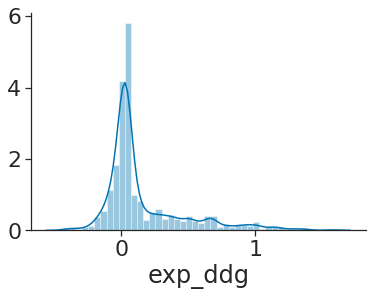

In [39]:
sns.distplot(all_data['exp_ddg'])
sns.despine()
plt.show()

In [40]:
def compute_density_df(data, min_n=0):
    half_window_size = 1
    bins = np.arange(
        math.floor(data[ddg_metric].min()) + half_window_size,
        9.6,
        0.1
    )
    lower_q = 0.25
    upper_q = 0.75
    density_dict = {
        key : []
        for key in [ddg_metric, 'median', 'lower_q', 'upper_q', 'n']
    }
    for bin_center in bins:
        data_i = data[
            data[ddg_metric].between(bin_center-half_window_size, bin_center+half_window_size)
        ]
        density_dict[ddg_metric].append(bin_center)
        density_dict['median'].append(data_i['exp_ddg'].quantile(0.5))
        density_dict['lower_q'].append(data_i['exp_ddg'].quantile(lower_q))
        density_dict['upper_q'].append(data_i['exp_ddg'].quantile(upper_q))
        density_dict['n'].append(len(data_i))

    df = pandas.DataFrame.from_dict(density_dict)
    df = df[df['n'] >= min_n]
    return df

EEHEE_rd3_0037
polar_hb_data 17
polar_nohb_data 170
hydrophobic_data 256


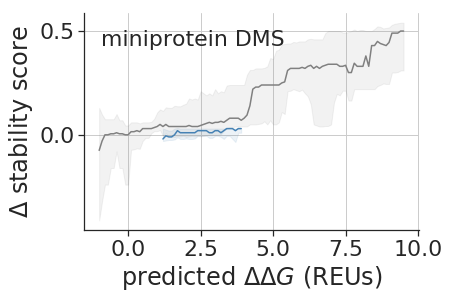

EEHEE_rd3_1498
polar_hb_data 17
polar_nohb_data 136
hydrophobic_data 306


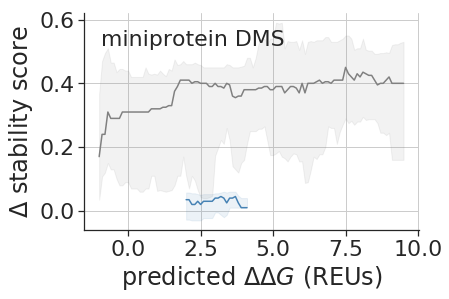

EEHEE_rd3_1716
polar_hb_data 68
polar_nohb_data 153
hydrophobic_data 307


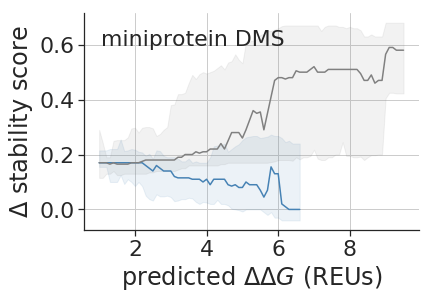

EHEE_rd1_0882
polar_hb_data 238
polar_nohb_data 119
hydrophobic_data 188


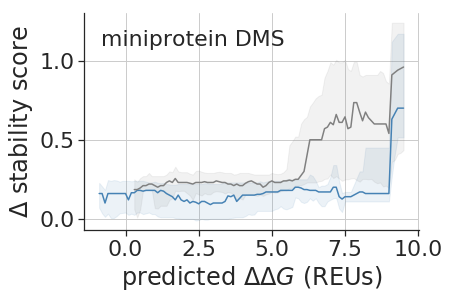

EHEE_rd2_0005
polar_hb_data 221
polar_nohb_data 34
hydrophobic_data 240


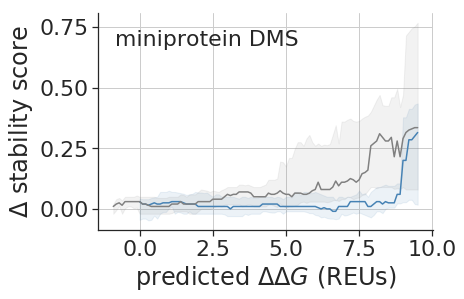

EHEE_rd3_0015
polar_hb_data 34
polar_nohb_data 204
hydrophobic_data 222


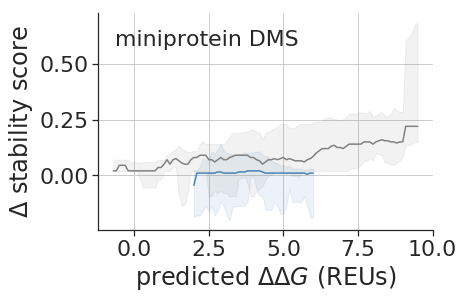

HEEH_rd2_0779
polar_hb_data 255
polar_nohb_data 119
hydrophobic_data 206


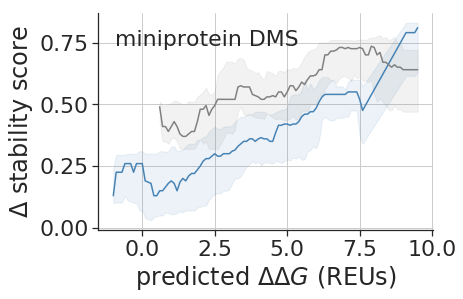

HEEH_rd3_0223
polar_hb_data 34
polar_nohb_data 238
hydrophobic_data 289


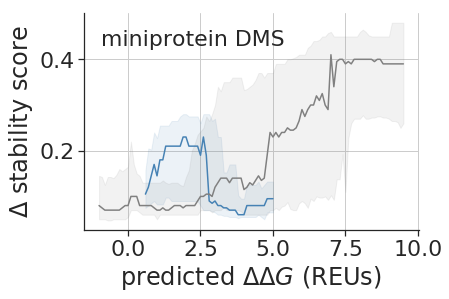

HEEH_rd3_0726
polar_hb_data 204
polar_nohb_data 153
hydrophobic_data 272


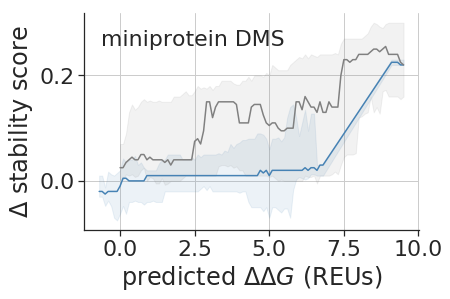

HEEH_rd3_0872
polar_hb_data 17
polar_nohb_data 204
hydrophobic_data 307


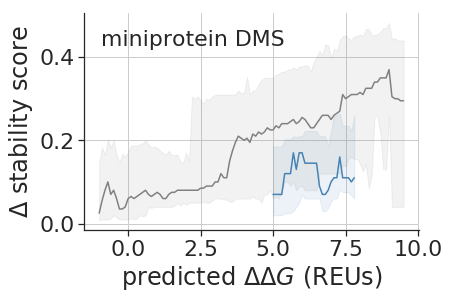

HHH_rd1_0142
polar_hb_data 306
polar_nohb_data 85
hydrophobic_data 239


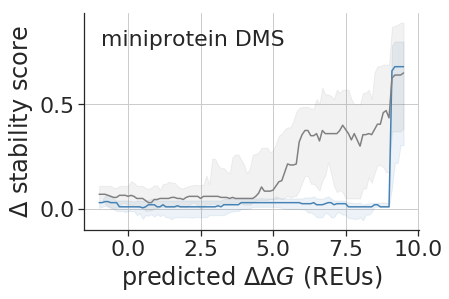

HHH_rd2_0134
polar_hb_data 272
polar_nohb_data 68
hydrophobic_data 221


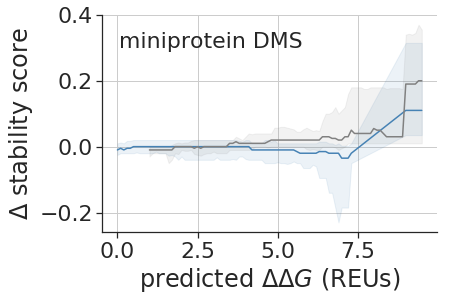

HHH_rd3_0138
polar_hb_data 221
polar_nohb_data 102
hydrophobic_data 255


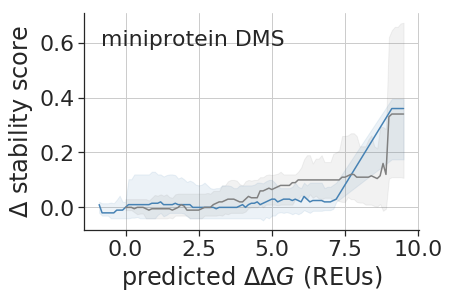

In [41]:
dataset = 'miniprotein_dms'
ddg_metric = 'beta16_ddg'
min_n = 5
#pdb = 'EEHEE_rd3_1498' # 'EEHEE_rd3_0037' # 'HEEH_rd2_0779' # 'EHEE_rd1_0882' # 
#pdbs = ['HHH_rd1_0142'] # 
pdbs = sorted(list(set(scores_df[scores_df['dataset'] == dataset]['pdb'])))
dfs_for_single_plot = []
for pdb in pdbs:
    print(pdb)
    hydrophobic_data = scores_df[
        (scores_df['wt_aa'].isin(hydrophobic_aas)) &
        (scores_df['pdb'] == pdb) &
        #(scores_df['n_hbonds'] >= 0) &
        (scores_df['dataset'] == dataset)
    ].copy()
    polar_data = scores_df[
        (scores_df['wt_aa'].isin(polar_aas)) &
        (scores_df['wt_aa'].isin(charged_aas)) &
        #(scores_df['site'].isin(sites)) &
        (scores_df['pdb'] == pdb) &
        (scores_df['n_hbonds'] > 0) &
        (scores_df['dataset'] == dataset)
    ].copy()
    polar_nohb_data = scores_df[
        (scores_df['wt_aa'].isin(polar_aas)) &
        (scores_df['wt_aa'].isin(charged_aas)) &
        #(scores_df['site'].isin(sites)) &
        (scores_df['pdb'] == pdb) &
        (scores_df['n_hbonds'] == 0) &
        (scores_df['dataset'] == dataset)
    ].copy()

    print('polar_hb_data', len(polar_data))
    print('polar_nohb_data', len(polar_nohb_data))
    print('hydrophobic_data', len(hydrophobic_data))

    density_df = compute_density_df(polar_data, min_n)
    if pdb == 'HHH_rd1_0142':
        density_df['dataset'] = dataset
        density_df['group'] = 'polar'
        dfs_for_single_plot.append(density_df)
    sns.lineplot(x=ddg_metric, y='median', data=density_df, color='steelblue')
    plt.fill_between(
        density_df[ddg_metric],
        density_df['lower_q'],\
        density_df['upper_q'],
        #facecolor="steelblue", # The fill color
        color='steelblue',       # The outline color
        alpha=0.1          # Transparency of the fill
    )

#     density_df = compute_density_df(polar_nohb_data, min_n)
#     sns.lineplot(x=ddg_metric, y='median', data=density_df, color='firebrick')
#     plt.fill_between(
#         density_df[ddg_metric],
#         density_df['lower_q'],\
#         density_df['upper_q'],
#         #facecolor="firebrick", # The fill color
#         color='firebrick',       # The outline color
#         alpha=0.1          # Transparency of the fill
#     )

    density_df = compute_density_df(hydrophobic_data, min_n)
    if pdb == 'HHH_rd1_0142':
        density_df['dataset'] = dataset
        density_df['group'] = 'hydrophobic'
        dfs_for_single_plot.append(density_df)
    sns.lineplot(x=ddg_metric, y='median', data=density_df, color='0.5')
    plt.fill_between(
        density_df[ddg_metric],
        density_df['lower_q'],\
        density_df['upper_q'],
        #facecolor="steelblue", # The fill color
        color='0.5',       # The outline color
        alpha=0.1          # Transparency of the fill
    )

    plt.annotate(
        'miniprotein DMS', (0.05, 0.85), #(-1, 0.55),
        xycoords='axes fraction', fontsize=22
    )
    #plt.yticks([0, 1])
    plt.xlabel('predicted $\Delta \Delta G$ (REUs)')
    plt.ylabel('$\Delta$ stability score')
    plt.grid()
    sns.despine()
    plt.show()

In [64]:
pdb = 'EEHEE_rd3_1498'
polar_data = scores_df[
    (scores_df['wt_aa'].isin(polar_aas)) &
    (scores_df['wt_aa'].isin(charged_aas)) &
    #(scores_df['site'].isin(sites)) &
    (scores_df['pdb'] == pdb) &
    (scores_df['n_hbonds'] > 0) &
    (scores_df['dataset'] == dataset)
].copy()
set(polar_data['site'])

{32}

In [65]:
polar_nohb_data[['mutation', 'n_hbonds']].head()

,mutation,n_hbonds
7251,E12A,0
7252,E12D,0
7253,E12F,0
7254,E12G,0
7255,E12H,0


**Observations**
* EEHEE_rd3_1498
    * see difference between polar_hb, polar_nohb, hydrophobic
* HHH_rd1_0142
    * see difference bewteen polars and hydrophobics, but not between polars

Analyze protein GB1 dataset


#--------
beta16.nostab-refit_ddg
all rmse = 4.23
all R = 0.71
all median stab muts = 1.0
rmse = 2.94
R = 0.88
median stab muts = 1.84

#--------
HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg
all rmse = 4.09
all R = 0.69
all median stab muts = 0.84
rmse = 1.89
R = 0.85
median stab muts = 0.29

#--------
HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg
all rmse = 4.06
all R = 0.69
all median stab muts = 0.65
rmse = 1.7
R = 0.84
median stab muts = -0.33


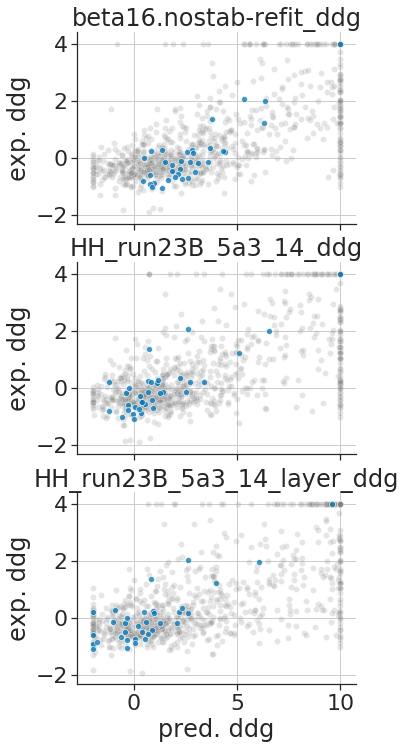

In [66]:
dataset = 'protein_gb1'
sites = [
    #4, 15, 19, 27, 28, 31, 32, 35, 36, 40, 46, 47, 50, # surface polars
    4, 15
    #27, 28, 31
    #31
    #6 # surface hydrophobic
    #54 # #30, # 5, # core
]
#sites = scsc_hbonding_sites
#sites = charged_sites
e_functions = [
    #'beta16_ddg',
    #'beta16_ddg',
    'beta16.nostab-refit_ddg',
    #'beta16_layer_ddg',
    #'beta16_uniform_ddg',
    #'RosettaFold_ddg',
    #'HH_run23B_sol_elec_dd2_simple_step169_ddg'
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg',
]

(fig, axs) = plt.subplots(
    nrows=len(e_functions), sharex=True, sharey=True,
    figsize=[5,4*len(e_functions)]
)
only_beneficial_or_neutral = False
if only_beneficial_or_neutral:
    print('only plotting data for beneficial/neutral muts')
for (i, e_function) in enumerate(e_functions):
    
    print('\n#--------')
    print(e_function)

    # Plot other sites
    data = scores_df[
        (scores_df['dataset'] == dataset) &
        (~scores_df['site'].isin(sites)) &
        (~scores_df[e_function].isnull()) &
        (~scores_df['site'].isnull())
    ].copy()
    if only_beneficial_or_neutral:
        data = data[data['ddg'] < 1]
    data[e_function] = data[e_function].clip(upper=10)
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(
        data['ddg'],
        data[e_function]
    ))
    (r, p) = scipy.stats.pearsonr(
        data['ddg'],
        data[e_function]
    )
    print(f'all rmse = {round(rmse, 2)}')
    print(f'all R = {round(r, 2)}')
    print(f'all median stab muts =', round(data[data['ddg'] < 0][e_function].median(), 2))

    sns.scatterplot(
        x=e_function, y='ddg', data=data, color='0.5', alpha=0.2,
        ax=axs[i]
    )

    # Plot sites of interest
    data = scores_df[
        (scores_df['dataset'] == dataset) &
        (scores_df['site'].isin(sites)) &
        #(~scores_df[e_function].isnull()) &
        (~scores_df['site'].isnull())
    ].copy()
    if only_beneficial_or_neutral:
        data = data[data['ddg'] < 1]
    data[e_function] = data[e_function].clip(upper=10)
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(
        data['ddg'],
        data[e_function]
    ))
    (r, p) = scipy.stats.pearsonr(
        data['ddg'],
        data[e_function]
    )
    print(f'rmse = {round(rmse, 2)}')
    print(f'R = {round(r, 2)}')
    print(f'median stab muts =', round(data[data['ddg'] < 0][e_function].median(), 2))
    sns.scatterplot(
        x=e_function, y='ddg', data=data, alpha=0.75,
        ax=axs[i]
    )
    
    axs[i].set(
        title = e_function.replace(
            'HH_run23B_sol_elec_dd2_simple_step169_1e_ddg',
            'HH_run23B_1e_ddg'
        ).replace(
            'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
            'HH_run23B_5a3_14'
        ),
        ylabel='exp. ddg'
    )
    axs[i].grid()
axs[i].set(xlabel='pred. ddg')
sns.despine()
plt.show()

Make line plots that compare patterns between hydrophobic amino acids and different classes of charged amino acids.

beta16.nostab-refit_ddg
polar_hb_data 153
polar_nohb_data 85
hydrophobic_data 340


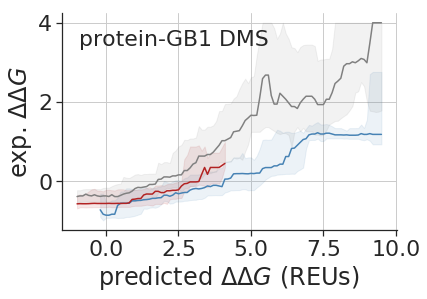

In [67]:
dataset = 'protein_gb1'
ddg_metric = 'beta16.nostab-refit_ddg' # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg' #
elec_int_metric = 'n_elec_int_relaxed'
hbond_metric = 'n_hbonds_relaxed' # 
no_hbond_metric = 'n_hbonds_relaxed'
min_n = 5
print(ddg_metric)
hydrophobic_data = scores_df[
    (scores_df['wt_aa'].isin(hydrophobic_aas)) &
    #(scores_df['n_hbonds'] >= 0) &
    ~(scores_df[ddg_metric].isnull()) &
    (scores_df['dataset'] == dataset)
].copy()
polar_data = scores_df[
    (scores_df['wt_aa'].isin(polar_aas)) &
    #(scores_df['wt_aa'].isin(['K', 'R'])) &
    (scores_df['wt_aa'].isin(charged_aas)) &
    #~(scores_df['wt_aa'].isin(['T'])) &
    #(scores_df['site'].isin(sites)) &
    (scores_df[hbond_metric] > 0) &
    ~(scores_df[ddg_metric].isnull()) &
    (scores_df['dataset'] == dataset)
].copy()
polar_nohb_data = scores_df[
    (scores_df['wt_aa'].isin(polar_aas)) &
    #(scores_df['wt_aa'].isin(['K', 'R'])) &
    (scores_df['wt_aa'].isin(charged_aas)) &
    #~(scores_df['wt_aa'].isin(['T'])) &
    #(scores_df['site'].isin(sites)) &
    (scores_df[elec_int_metric] == 0) &
    (scores_df[hbond_metric] == 0) &
    (scores_df[no_hbond_metric] == 0) &
    ~(scores_df[ddg_metric].isnull()) &
    (scores_df['dataset'] == dataset)
].copy()

print('polar_hb_data', len(polar_data))
print('polar_nohb_data', len(polar_nohb_data))
print('hydrophobic_data', len(hydrophobic_data))

density_df = compute_density_df(polar_data, min_n)
if len(dfs_for_single_plot) == 2:
    density_df['dataset'] = dataset
    if 'beta16.nostab-refit_ddg' in density_df.columns.values:
        density_df['beta16_ddg'] = density_df['beta16.nostab-refit_ddg']
    density_df['group'] = 'polar'
    dfs_for_single_plot.append(density_df)
sns.lineplot(x=ddg_metric, y='median', data=density_df, color='steelblue')
plt.fill_between(
    density_df[ddg_metric],
    density_df['lower_q'],\
    density_df['upper_q'],
    #facecolor="steelblue", # The fill color
    color='steelblue',       # The outline color
    alpha=0.1          # Transparency of the fill
)

density_df = compute_density_df(polar_nohb_data, min_n)
sns.lineplot(x=ddg_metric, y='median', data=density_df, color='firebrick')
plt.fill_between(
    density_df[ddg_metric],
    density_df['lower_q'],\
    density_df['upper_q'],
    #facecolor="firebrick", # The fill color
    color='firebrick',       # The outline color
    alpha=0.1          # Transparency of the fill
)

density_df = compute_density_df(hydrophobic_data, min_n)
if len(dfs_for_single_plot) == 3:
    density_df['dataset'] = dataset
    if 'beta16.nostab-refit_ddg' in density_df.columns.values:
        density_df['beta16_ddg'] = density_df['beta16.nostab-refit_ddg']
    density_df['group'] = 'hydrophobic'
    dfs_for_single_plot.append(density_df)
sns.lineplot(x=ddg_metric, y='median', data=density_df, color='0.5')
plt.fill_between(
    density_df[ddg_metric],
    density_df['lower_q'],\
    density_df['upper_q'],
    #facecolor="steelblue", # The fill color
    color='0.5',       # The outline color
    alpha=0.1          # Transparency of the fill
)

plt.annotate(
    'protein-GB1 DMS', (0.05, 0.85), #(-1, 0.55),
    xycoords='axes fraction', fontsize=22
)
plt.xlabel('predicted $\Delta \Delta G$ (REUs)')
plt.ylabel('exp. $\Delta \Delta G$')
plt.grid()
sns.despine()
plt.show()

In [68]:
polar_data[
    (polar_data[ddg_metric] > 7.5) &
    (polar_data['exp_ddg'] < 2)
][['mutation', 'exp_ddg', 'beta16.nostab-refit_ddg', ddg_metric]].head()

,mutation,exp_ddg,beta16.nostab-refit_ddg,beta16.nostab-refit_ddg
102,D22A,1.078,7.734000,7.734000
104,D22F,1.075,9.349667,9.349667
105,D22G,1.028,8.994000,8.994000
109,D22L,1.175,7.795000,7.795000
110,D22M,1.346,9.638000,9.638000


In [69]:
polar_nohb_data[
    (polar_nohb_data[ddg_metric] > 7.5) &
    (polar_nohb_data['exp_ddg'] < 2)
][['mutation', 'exp_ddg', 'beta16.nostab-refit_ddg', ddg_metric]].head()

,mutation,exp_ddg,beta16.nostab-refit_ddg,beta16.nostab-refit_ddg
435,K28P,1.23,10.0,10.0


In [70]:
set(polar_data['site'])

{4, 10, 15, 22, 36, 46, 47, 50, 56}

In [71]:
set(polar_nohb_data['site'])

{13, 19, 28, 40, 42}

In [72]:
set(polar_data['wt_aa'])

{'D', 'E', 'K'}

In [73]:
set(polar_nohb_data['wt_aa'])

{'D', 'E', 'K'}

ddG benchmark dataset

beta16_ddg
n_hbonds_relaxed n_hbonds_relaxed
polar_hb_data 390
polar_nohb_data 235
hydrophobic_data 1402


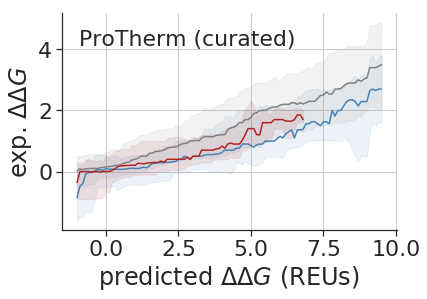

In [74]:
dataset = 'ddg_benchmark'
ddg_metric = 'beta16_ddg' # 'beta16_stab_ddg' # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg' #
sasa_cutoff = 0.1
hbond_metric = 'n_hbonds_relaxed' # 'n_charged_scsc_hbonds_relaxed'
no_hbond_metric = 'n_hbonds_relaxed'
min_n = 5
classifier = 'positive to hydrophobic' # 'negative to positive'

print(ddg_metric)
print(hbond_metric, no_hbond_metric)
hydrophobic_data = scores_df[
    (scores_df['wt_aa'].isin(hydrophobic_aas)) &
    (scores_df['dataset'] == dataset)
].copy()
polar_data = scores_df[
    (scores_df['wt_aa'].isin(polar_aas)) &
    (scores_df['wt_aa'].isin(charged_aas)) &
    #(scores_df['wt_aa'].isin(['E', 'D', 'R', 'K'])) &
    #(scores_df['classifiers'].str.contains(classifier)) &
    (scores_df['sasa'] > sasa_cutoff) &
    #(scores_df['sasa'] < 0.1) &
    #(scores_df[hbond_metric] > 0) &
    (scores_df[hbond_metric] > 0) &
    (scores_df['dataset'] == dataset)
].copy()
polar_nohb_data = scores_df[
    (scores_df['wt_aa'].isin(polar_aas)) &
    (scores_df['wt_aa'].isin(charged_aas)) &
    #(scores_df['wt_aa'].isin(['E', 'D', 'R', 'K'])) &
    #(scores_df['classifiers'].str.contains(classifier)) &
    (scores_df['sasa'] > sasa_cutoff) &
    #(scores_df['sasa'] < 0.1) &
    (scores_df[no_hbond_metric] == 0) &
    (scores_df['dataset'] == dataset)
].copy()

print('polar_hb_data', len(polar_data))
print('polar_nohb_data', len(polar_nohb_data))
print('hydrophobic_data', len(hydrophobic_data))

density_df = compute_density_df(polar_data, min_n)
if len(dfs_for_single_plot) == 4:
    density_df['dataset'] = dataset
    density_df['group'] = 'polar'
    dfs_for_single_plot.append(density_df)
sns.lineplot(x=ddg_metric, y='median', data=density_df, color='steelblue')
plt.fill_between(
    density_df[ddg_metric],
    density_df['lower_q'],\
    density_df['upper_q'],
    #facecolor="steelblue", # The fill color
    color='steelblue',       # The outline color
    alpha=0.1          # Transparency of the fill
)

density_df = compute_density_df(polar_nohb_data, min_n)
sns.lineplot(x=ddg_metric, y='median', data=density_df, color='firebrick')
plt.fill_between(
    density_df[ddg_metric],
    density_df['lower_q'],\
    density_df['upper_q'],
    #facecolor="steelblue", # The fill color
    color='firebrick',       # The outline color
    alpha=0.1          # Transparency of the fill
)

density_df = compute_density_df(hydrophobic_data, min_n)
if len(dfs_for_single_plot) == 5:
    density_df['dataset'] = dataset
    density_df['group'] = 'hydrophobic'
    dfs_for_single_plot.append(density_df)
sns.lineplot(x=ddg_metric, y='median', data=density_df, color='0.5')
plt.fill_between(
    density_df[ddg_metric],
    density_df['lower_q'],\
    density_df['upper_q'],
    #facecolor="steelblue", # The fill color
    color='0.5',       # The outline color
    alpha=0.1          # Transparency of the fill
)

plt.annotate(
    'ProTherm (curated)', (0.05, 0.85), #(-1, 0.55),
    xycoords='axes fraction', fontsize=22
)
#plt.title('$\Delta \Delta G$')
plt.xlabel('predicted $\Delta \Delta G$ (REUs)')
plt.ylabel('exp. $\Delta \Delta G$')
plt.grid()
sns.despine()
plt.show()

In [75]:
polar_data[[
    'pdb', 'mutation', 'exp_ddg', 'beta16_ddg',
    'n_hbonds_relaxed', 'n_charged_scsc_hbonds_relaxed'
]].tail()

,pdb,mutation,exp_ddg,beta16_ddg,n_hbonds_relaxed,n_charged_scsc_hbonds_relaxed
2874,4LYZ,E35Q,0.530000,1.3746,2.0,0.0
2896,4LYZ,K13D,6.692161,8.2530,1.0,0.0
2906,4LYZ,R114H,-0.680000,0.7690,1.0,0.0
2908,4LYZ,R68K,0.040000,0.2710,2.0,0.0
2909,4LYZ,R73K,-0.230000,1.9220,1.0,0.0


In [76]:
polar_nohb_data[[
    'pdb', 'mutation', 'exp_ddg', 'beta16_ddg',
    'n_hbonds_relaxed', 'n_charged_scsc_hbonds_relaxed'
]].head()

,pdb,mutation,exp_ddg,beta16_ddg,n_hbonds_relaxed,n_charged_scsc_hbonds_relaxed
23,1A2P,D44E,0.32000,-0.055,0.0,0.0
85,1A2P,K108R,-0.78000,-0.577,0.0,0.0
86,1A2P,K19R,-0.88000,-0.888,0.0,0.0
90,1A2P,K66A,-0.98000,-0.818,0.0,0.0
175,1AAR,K29N,1.67304,3.052,0.0,0.0


Make a single plot with each of the above datasets

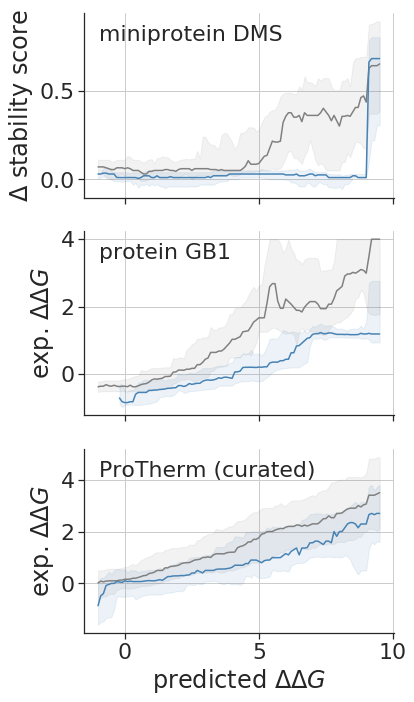

In [85]:
ddg_metric = 'beta16_ddg'
df = pandas.concat(dfs_for_single_plot, sort=False)
datasets = ['miniprotein_dms', 'protein_gb1', 'ddg_benchmark']
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, figsize=[6,10]
)
color_dict = {
    'hydrophobic' : '0.5',
    'polar' : 'steelblue'
}
title_dict = {
    'miniprotein_dms' : 'miniprotein DMS',
    'protein_gb1' : 'protein GB1',
    'ddg_benchmark' : 'ProTherm (curated)',
}
ylabel_dict = {
    'miniprotein_dms' : '$\Delta$ stability score',
    'protein_gb1' : 'exp. $\Delta \Delta G$',
    'ddg_benchmark' : 'exp. $\Delta \Delta G$',
}
for (i, dataset) in enumerate(datasets):
    for group in ['hydrophobic', 'polar']:        
        density_df = df[
            (df['dataset'] == dataset) &
            (df['group'] == group)
        ]
        sns.lineplot(
            x=ddg_metric, y='median', data=density_df,
            color=color_dict[group], ax=axs[i]
        )
        axs[i].fill_between(
            density_df[ddg_metric],
            density_df['lower_q'],\
            density_df['upper_q'],
            #facecolor="steelblue", # The fill color
            color=color_dict[group],       # The outline color
            alpha=0.1          # Transparency of the fill
        )
    axs[i].annotate(
        title_dict[dataset], (0.05, 0.85), #(-1, 0.55),
        xycoords='axes fraction', fontsize=22
    )
    axs[i].set(
        ylabel=ylabel_dict[dataset],
        xlabel='predicted $\Delta \Delta G$'
    )
    axs[i].grid()
    
plt.tight_layout()
sns.despine()
plt.show()

Compare energy functions in their ability to predict the protherm data

In [44]:
data = scores_df[scores_df['dataset'] == 'ddg_benchmark'].copy()
data['exp_ddg'] = data['exp_ddg'].clip(lower=-5, upper=5)

In [45]:
balanced_pt_ids = set(ddg2_df['Protherm ID'])
print(len(balanced_pt_ids))

768


beta16_ddg
765 0.54 0.0


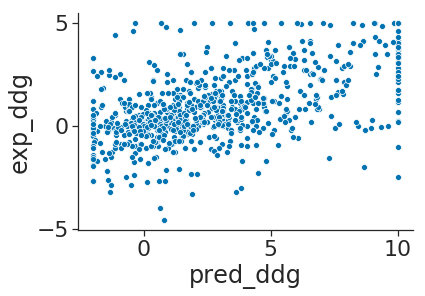

beta16_stab_ddg
765 0.54 0.0


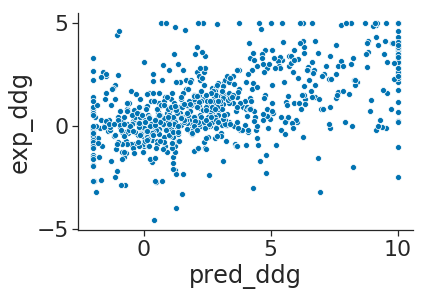

beta16_layer_ddg
765 0.56 0.0


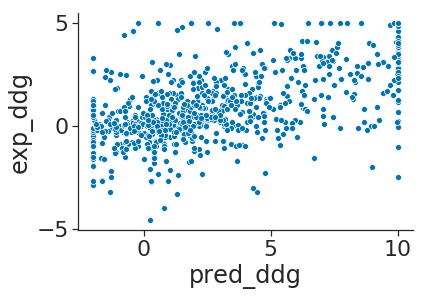

beta16_uniform_ddg
765 0.53 0.0


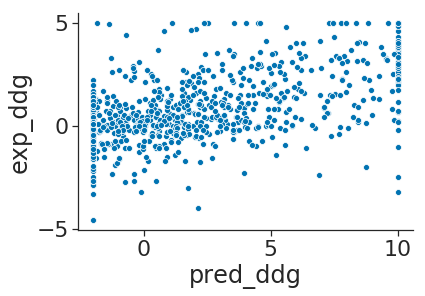

HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg
712 0.49 0.0


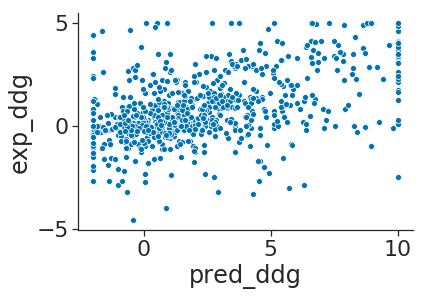

HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg
712 0.52 0.0


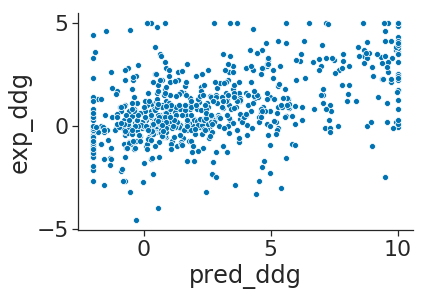

In [46]:
metrics = [
    'beta16_ddg',
    'beta16_stab_ddg',
    'beta16_layer_ddg',
    'beta16_uniform_ddg',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg',
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_layer_ddg',
]
for metric in metrics:
    print(metric)
    data_i = data[
        (data['Protherm ID'].isin(balanced_pt_ids)) &
        #(data['sasa'] > 0.5) &
        (~data[metric].isnull())
    ]
    (r, p) = scipy.stats.pearsonr(data_i[metric], data_i['exp_ddg'])
    print(len(data_i), round(r, 2), round(p, 2))
    sns.scatterplot(x=metric, y='exp_ddg', data=data_i)
    plt.xlabel('pred_ddg')
    sns.despine()
    plt.show()

In [66]:
data[
    (data['exp_ddg'] <= 0) &
    (data['beta16_ddg'] > 7)
][[
    'pdb', 'mutation', 'exp_ddg',
    'beta16_ddg', 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg'
]].head(n=10)

,pdb,mutation,exp_ddg,beta16_ddg,HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14_ddg
111,1A2P,R110A,-0.07,8.9410,6.7630
253,1BP2,F22A,-0.50,10.0000,9.7188
254,1BP2,F22I,-2.70,7.1144,10.0000
399,1C2R,Y75C,0.00,8.4280,8.2690
520,1DIL,A53L,-0.81,10.0000,NaN
530,1DYJ,G121C,-0.09,8.9588,4.2390
531,1DYJ,G121D,-0.19,8.7136,-2.0000
546,1DYJ,G95A,-1.30,10.0000,10.0000
608,1DYJ,W22L,-0.10,9.4066,8.3458
650,1FLV,A101L,-0.08,10.0000,NaN


Observations:

Outliers with low exp ddg but high pred ddg
* changes that involve removing salt bridges
    * 1A2P R110A
* changes that appear to create large clashes, which likely involve some kind of structural rearrangement
    * 1DIL A53L
    * 1DYJ G121A
* changes that appear to create large voids
    * 1BP2 F22A

Look at subsets of mutations

beta16_ddg large to small
448 0.66 0.0


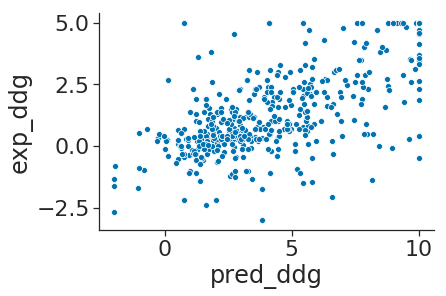

beta16_ddg small to large
142 0.36 0.0


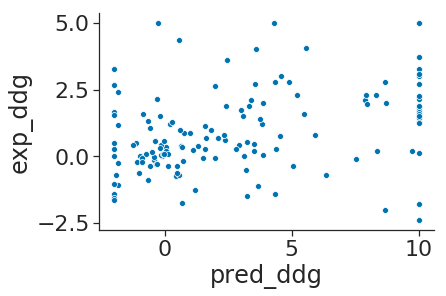

In [132]:
metric = 'beta16_ddg'
classifiers = [
    #'negative to positive',
    #'positive to negative',
    #'negative to hydrophobic',
    #'positive to hydrophobic'
    'large to small',
    'small to large'
]
for classifier in classifiers:
    print(metric, classifier)
    data_i = data[
        #(data['Protherm ID'].isin(balanced_pt_ids)) &
        (data['classifiers'].str.contains(classifier)) &
        #(data['sasa'] > 0.5) &
        (~data[metric].isnull())
    ]
    #data_i['classifiers'].head()
    (r, p) = scipy.stats.pearsonr(data_i[metric], data_i['exp_ddg'])
    print(len(data_i), round(r, 2), round(p, 2))
    sns.scatterplot(x=metric, y='exp_ddg', data=data_i)
    plt.xlabel('pred_ddg')
    sns.despine()
    plt.show()

In [116]:
set(data['classifiers'])

{"'charge to charge' 'buried'",
 "'charge to charge' 'surface'",
 "'hydrophobic to hydrophobic' 'buried'",
 "'hydrophobic to hydrophobic' 'surface'",
 "'hydrophobic to polar' 'hydrophobic to negative' 'buried'",
 "'hydrophobic to polar' 'hydrophobic to negative' 'surface'",
 "'hydrophobic to polar' 'hydrophobic to non-charged polar' 'buried'",
 "'hydrophobic to polar' 'hydrophobic to non-charged polar' 'surface'",
 "'hydrophobic to polar' 'hydrophobic to positive' 'buried'",
 "'hydrophobic to polar' 'hydrophobic to positive' 'surface'",
 "'involves cysteine' 'buried'",
 "'involves cysteine' 'surface'",
 "'involves proline' 'buried'",
 "'involves proline' 'surface'",
 "'large to small' 'hydrophobic to hydrophobic' 'buried'",
 "'large to small' 'hydrophobic to hydrophobic' 'surface'",
 "'large to small' 'hydrophobic to polar' 'hydrophobic to non-charged polar' 'buried'",
 "'large to small' 'involves cysteine' 'buried'",
 "'large to small' 'involves cysteine' 'surface'",
 "'large to small